In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import sys
!pip install tensorflow_hub

In [ ]:
name_home = '/content/drive/My Drive/Colab Notebooks/GDG_Study/openCV_Study/'
os.chdir(name_home + 'fast_RCNN/')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/GDG_Study/openCV_Study/fast_RCNN'

In [ ]:
os.listdir()

['fast_rcnn.ipynb',
 'fast_rcnn.py',
 '_path.py',
 '.ipynb_checkpoints',
 '__pycache__']

In [ ]:
"""
# Fast R-CNN 설명 및 정리 :: 프라이데이=https://bit.ly/3lWxz4i
# faster R-CNN 예제 코드 = https://bit.ly/356b4Do
"""
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

# from six.moves.urllib.request import urlopen
# from six import BytesIO

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
# from PIL import ImageOps

from _path import (DIR_SRC, get_cut_dir, stop_if_none)


# functions : for a few initial path setting



In [ ]:
# 이번에는 미리 학습된 모델인 inception_resnet_v2 불러온다.
# 모듈안에는 구조나 가중치가 다 정해져 있기 때문에 학습은 할 필요가 없다
# 구조를 보고 싶으면 detector.summary()를 통해 확인 가능하다

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
# module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def display_image(image):
    """ 이미지를 그리는 함수 """
    fig = plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image)

In [ ]:
def draw_bounding_box_on_image(
        image, ymin, xmin, ymax, xmax,
        color, font, thickness=4, display_str_list=()):
    """이미지에 박스를 그려주는 함수"""
    # 이미지에 경계상자 그리기
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size  # 이미지 원사이즈
    (left, right, top, bottom) = (
                        xmin * im_width, 
                        xmax * im_width,
                        ymin * im_height, 
                        ymax * im_height,
                    )
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)], width=thickness, fill=color)

    # 이미지 상단에 글자넣기
    # 만약 박스이미지가 이미지를 초과하면 하단에 글씨를 넣는다

    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

    # 각각의 디스플레이마다 상단과 하단의 여백을 0.05로 설정한다.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height

    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)

        draw.rectangle(
                [
                    (left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom),
                ],
                fill=color,
            )

        draw.text(
                (
                    left+margin, 
                    text_bottom-text_height-margin
                ),
                display_str,
                fill="black",
                font=font
            )

    text_bottom -= text_height - 2 * margin

In [ ]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """ # to draw bound boxes on the image """
    colors = list(ImageColor.colormap.values())
    # 폰트지정
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)

    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()


    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:                      #최소의 값 이상인 값 찾기
            ymin, xmin, ymax, xmax = tuple(boxes[i])    #박스 좌표값
            display_str = "{}:{}%".format(
                    class_names[i].decode("ascii"),
                    int(100*scores[i]),
                )
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,ymin,xmin,
                ymax,xmax,color,
                font,display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [ ]:
def load_img(path):
    """이미지를 불러오는 함수"""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [ ]:
def run_detector(detector, path):
    """
    # 이미지를 넣어 faster R-CNN을 실행을 하는 함수다
    # 실행순서는 이미지 불러오기 -> 이미지 타입변경 -> 모델예측 ->
    # 이미지 박스그리기 -> 이미지 출력 순으로 실행
    """
    img = load_img(path)
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}
    print("이미지에서 찾은 %d개의 객체." % len(result["detection_scores"]))
    print("추론한 시간: ", end_time-start_time)
    
    image_with_boxes = draw_boxes(
                            img.numpy(), 
                            result["detection_boxes"],
                            result["detection_class_entities"], 
                            result["detection_scores"],
                        )
    
    display_image(image_with_boxes)
    
    return image_with_boxes

이미지에서 찾은 100개의 객체.
추론한 시간:  35.83187294006348


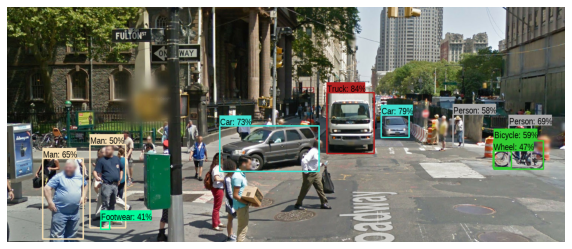

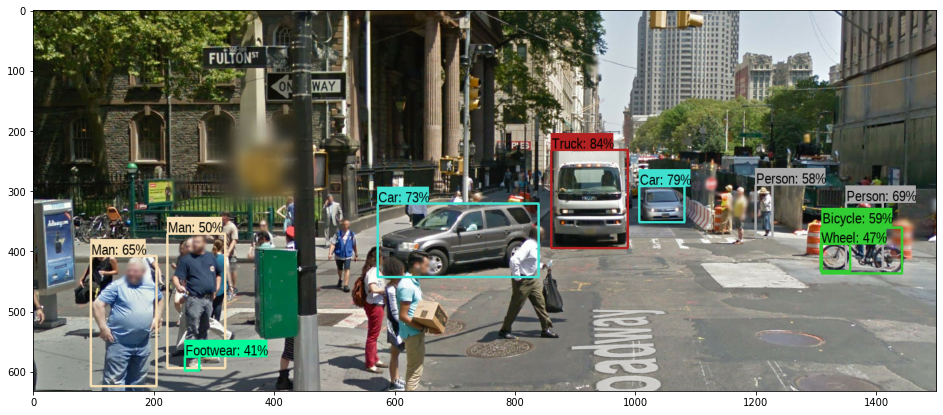

In [ ]:
path = name_home + 'src/google_street_view.jpg'
_1 = run_detector(detector, path)

fig, ax = plt.subplots(1,1, figsize=(20,7))
plt.imshow(_1)
plt.show()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


이미지에서 찾은 100개의 객체.
추론한 시간:  6.48668360710144


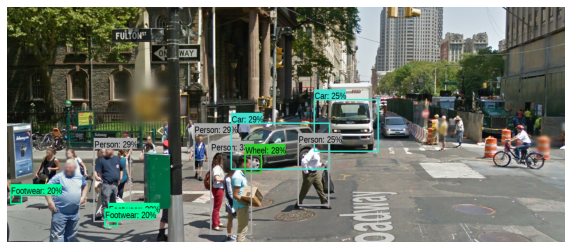

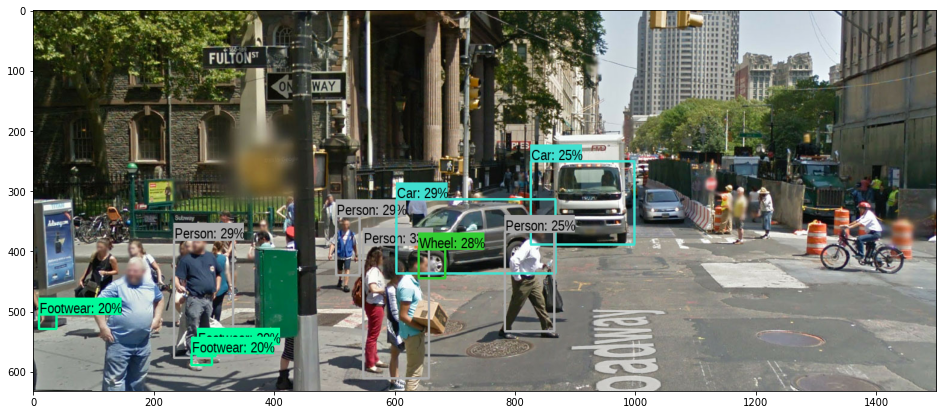

In [ ]:
# module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

detector = hub.load(module_handle).signatures['default']

path = name_home + 'src/google_street_view.jpg'
_2 = run_detector(detector, path)

fig, ax = plt.subplots(1,1, figsize=(20,7))
plt.imshow(_2)
plt.show()


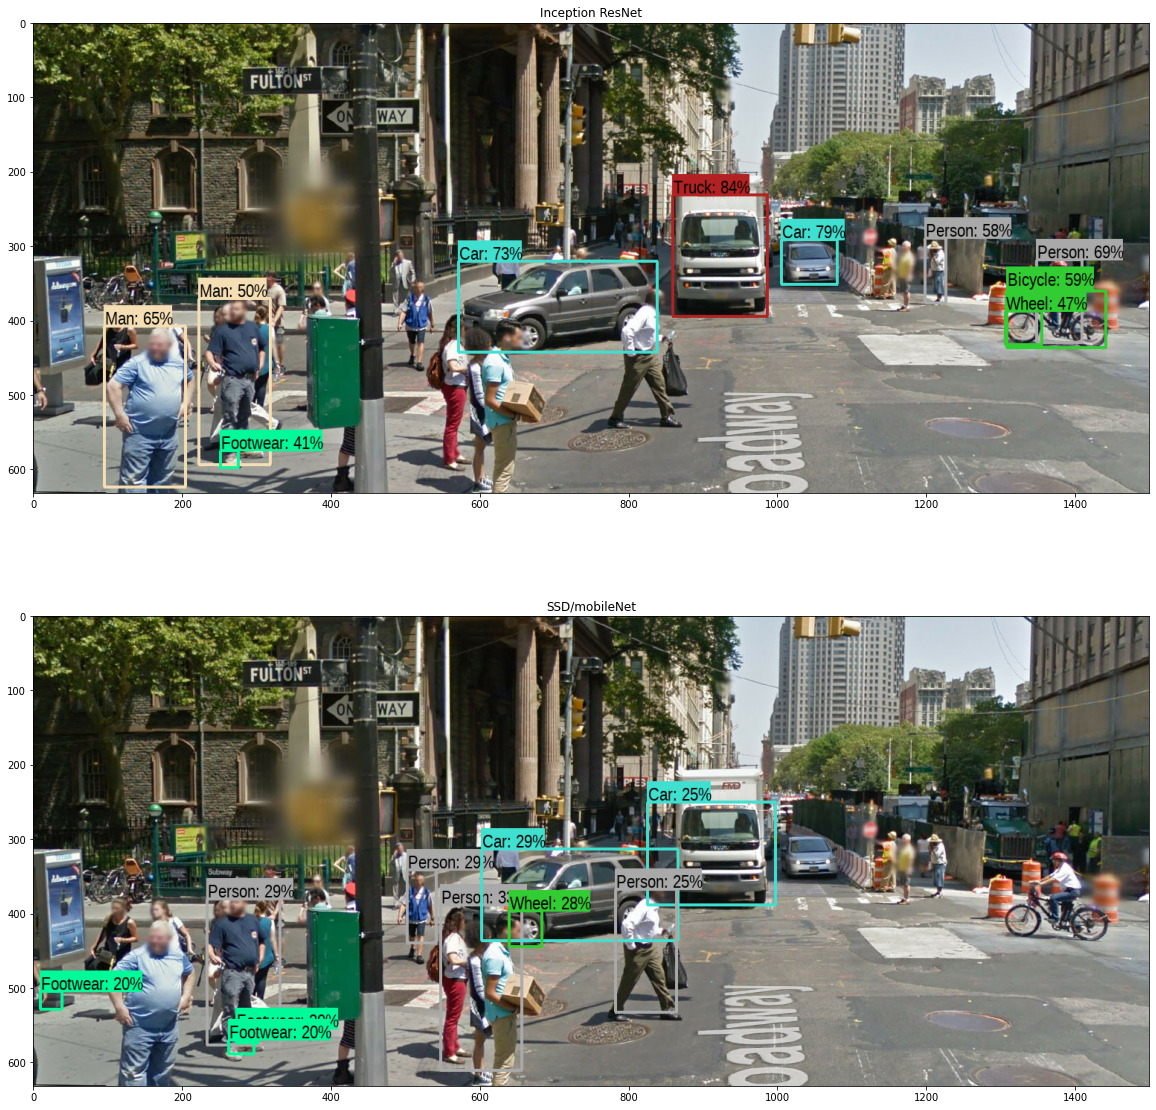

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(20,20))
axes[0].imshow(_1)
axes[0].set_title('Inception ResNet')

axes[1].imshow(_2)
axes[1].set_title('SSD/mobileNet')

plt.show()

이미지에서 찾은 100개의 객체.
추론한 시간:  0.3405418395996094


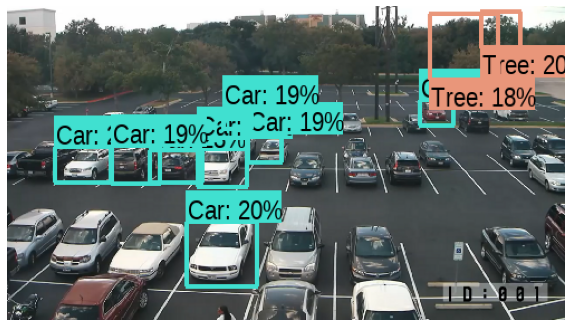

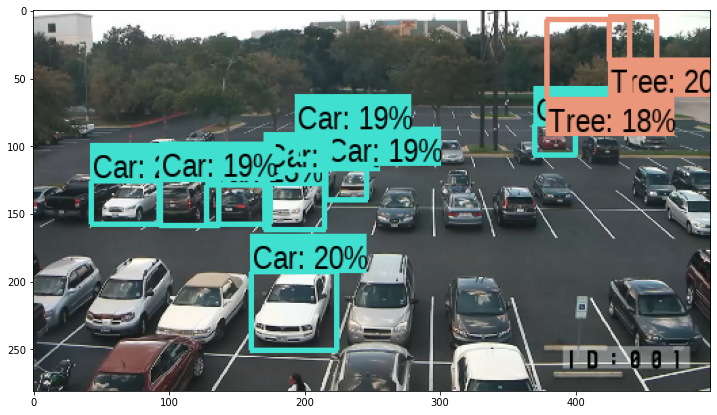

In [ ]:
path = name_home + 'src/empty_parking_lot.png'
_ = run_detector(detector, path)

fig, ax = plt.subplots(1,1, figsize=(20,7))
plt.imshow(_)
plt.show()

이미지에서 찾은 100개의 객체.
추론한 시간:  0.3115997314453125


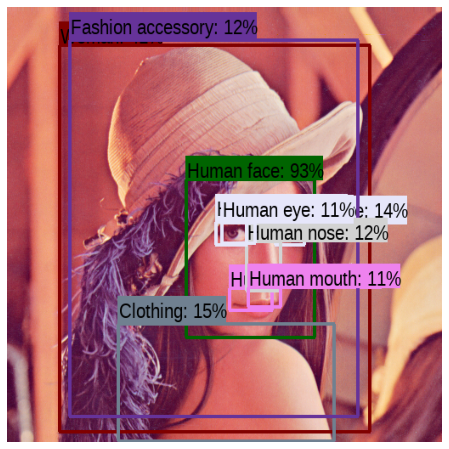

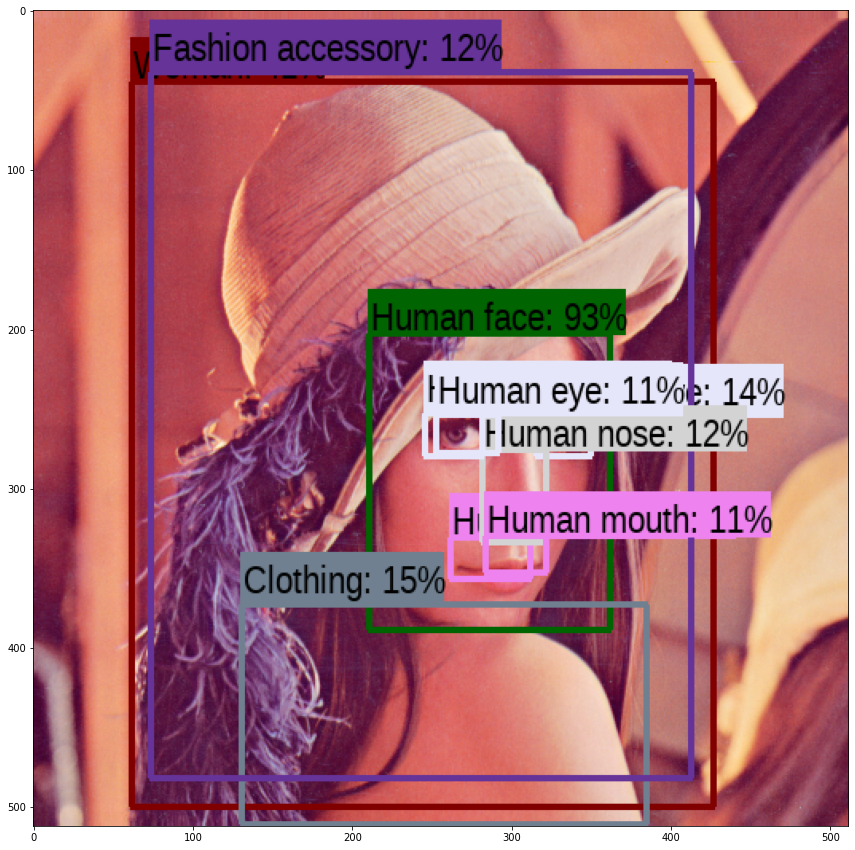

In [ ]:
path = name_home + 'src/Lenna.png'
_ = run_detector(detector, path)

fig, ax = plt.subplots(1,1, figsize=(15,15))
plt.imshow(_)
plt.show()